In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 24)
(17248, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_FR_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FR_swinging = Y_footsteps_accelerations_absolute[idxs]

## Predict FR foot -> x

In [8]:
X_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.09097511,  0.01569571,  0.03546102, -0.07442539,
        0.25578701,  0.13131595, -0.38037282,  0.22266933, -0.12780198,
       -0.381951  , -0.27515733,  0.12599015, -0.38960645, -0.2416217 ,
       -0.12631081, -0.38173601,  0.        ,  1.        ])

In [9]:
Y_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.06153266, -0.00069727,  0.06077899, -0.00427389])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9931168830632253
RMSE:  0.015233507214596079
The lowest error is:  3.3303214825683436e-05
The highest error is:  0.06100326971963055
The avg. error is:  0.011405424757502234


In [12]:
model_fr_relative_swinging_x.coef_

array([[ 0.38168104,  0.15677369,  0.44126682,  0.30818634, -1.62732594,
         0.34270941,  0.44436638,  0.1156409 , -1.20889462, -0.88097806]])

In [13]:
model_fr_relative_swinging_x.intercept_

array([-0.0350675])

In [20]:
# with velocity
inp = np.array([[0.94, 0.9, 0.368, 0.132, 0.0910, -0.127, -0.405, 0.125, -0.124, -0.126]])
out = model_fr_relative_swinging_x.coef_ @ inp.T
out += model_fr_relative_swinging_x.intercept_
print(out)

[[0.57165792]]


In [48]:
# wo velocity
inp = np.array([[0.1, 0.9, 0.311, 0.120, 0.127, -0.115, -0.368, 0.136, -0.186, -0.138]])
out = model_fr_relative_swinging_x.coef_ @ inp.T
out += model_fr_relative_swinging_x.intercept_
print(out)

[[0.44082853]]


Text(0, 0.5, 'Predictions')

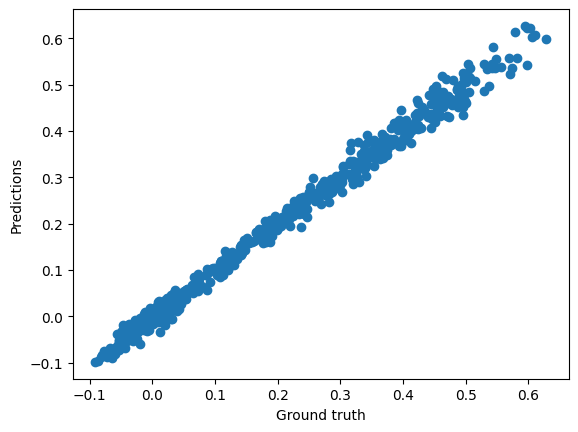

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
for idx, prediction in enumerate(predictions):
    print(f'{X_test[idx, 0]}->{X_test[idx, 1]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

-0.021730007603764534->0.0. Groundtruth: [0.02854717]. Predicted: [0.01681027]
0.48199301958084106->0.5. Groundtruth: [0.27861017]. Predicted: [0.26557658]
-0.029003754258155823->0.0. Groundtruth: [0.02335728]. Predicted: [-0.00382814]
-0.04101374000310898->0.0. Groundtruth: [0.02557401]. Predicted: [-0.00188109]
0.7537105679512024->0.7. Groundtruth: [0.41292321]. Predicted: [0.40034784]
0.9372304081916809->0.0. Groundtruth: [0.42452819]. Predicted: [0.40407553]
0.015399370342493057->0.0. Groundtruth: [0.00874272]. Predicted: [0.00743939]
0.6688855290412903->0.6. Groundtruth: [0.3536421]. Predicted: [0.36195809]
0.31494373083114624->0.0. Groundtruth: [0.12296998]. Predicted: [0.11838001]
0.014360846020281315->0.0. Groundtruth: [-0.00508904]. Predicted: [0.00432691]
-0.0025936749298125505->0.0. Groundtruth: [-0.04093066]. Predicted: [-0.03740651]
0.2707722783088684->0.5. Groundtruth: [0.2052983]. Predicted: [0.1946911]
0.010118350386619568->0.1. Groundtruth: [0.01069697]. Predicted: [0.

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.8802095356934301
RMSE:  0.00773343530629071
The lowest error is:  5.827796275269595e-06
The highest error is:  0.026521656173226466
The avg. error is:  0.0059234149243820415


In [17]:
model_fr_relative_swinging_y.coef_

array([[-0.07741833,  0.01497329, -0.51843135,  0.45648639, -0.39901844,
        -1.47489132,  0.32354615, -0.29951593,  0.8586617 ,  0.58523714]])

In [18]:
model_fr_relative_swinging_y.intercept_

array([0.38954682])

Text(0, 0.5, 'Predictions')

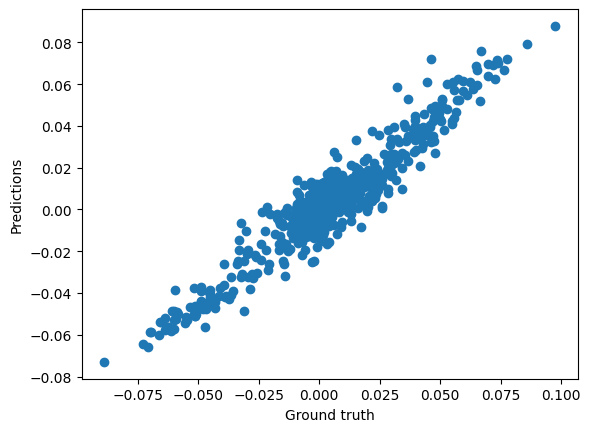

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [36]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')